In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, cheby1

import librosa


y, fs = librosa.load("inputs/scale.wav", sr=None)

y = librosa.to_mono(y)

print(f"Sound clip is {len(y)/fs} seconds long")
print(fs)
window_size = int(fs* 0.25)

print(window_size)

bounds = [80, 1000]

# f0 = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
# print(f0)

Sound clip is 9.195102040816327 seconds long
44100
11025


[ 8.27780387e-06  0.00000000e+00 -3.31112155e-05  0.00000000e+00
  4.96668232e-05  0.00000000e+00 -3.31112155e-05  0.00000000e+00
  8.27780387e-06] [  1.          -7.70121417  25.96020907 -50.03033249  60.29136697
 -46.52381732  22.44893677  -6.19298225   0.74783342]
(405504,)
8


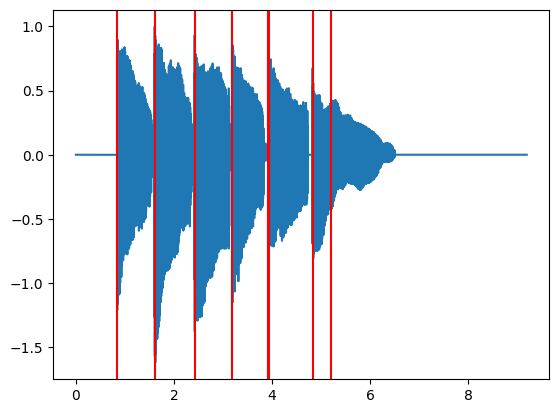

In [4]:


order = 4
low = 120.0
high= 900.0
b,a = butter(order, [low, high], fs=fs, btype='band')
# b,a = butter(order, [low, high], fs=fs, btype='band')
print(b, a)
y[np.abs(y) < 0.04] = 0



filtered_sound = lfilter(b, a ,y)
y = filtered_sound


maxim = np.max(y)
y = y/maxim


onset_frames = librosa.onset.onset_detect(y=y)
onset_samples = librosa.frames_to_samples(onset_frames)


print(y.shape)

print(len(onset_samples))

time_disc = np.linspace(0, len(y)/ fs, num=len(y))
plt.plot(time_disc,y)

for sample in onset_samples:
    plt.axvline(x=sample/fs, color="red")


plt.savefig("onsets.png")
plt.show()


In [3]:
def ACF(y, window_size, t, lag):    
    return np.sum(
        y[t : t + window_size] *
        y[lag + t : lag + t + window_size]
    )


def detect_pitch_ACF(y, window_size, t, fs, bounds):
    ACF_vals = [ACF(y, window_size, t, i) for i in range(*bounds)]
    sample = np.argmax(ACF_vals) + bounds[0]
    return fs / sample



def DF(y, window_size, t, lag):
    return ACF(y, window_size, t, 0)\
        + ACF(y, window_size, t + lag, 0)\
        - (2 * ACF(y, window_size, t, lag))



def CMNDF(y, window_size, t, lag):
    if lag == 0:
        return 1
    return DF(y, window_size, t, lag)\
        / np.sum([DF(y, window_size, t, j + 1) for j in range(lag)])


def detect_pitch_CMNDF(y, window_size, t, fs, bounds):
    CMNDF_vals = [CMNDF(y, window_size, t, i) for i in range(1, fs*3)]
    lower_bound = max(bounds[0], 0)
    upper_bound = min(bounds[1], len(CMNDF_vals))
    sample = np.argmin(
        CMNDF_vals[lower_bound:upper_bound]
    ) + lower_bound
    return fs / sample


def memo_CMNDF(y, window_size, t, lag_max):
    running_sum = 0
    vals = []
    for lag in range(0, lag_max):
        if lag == 0:
            vals.append(1)
            running_sum += 0
        else:
            running_sum += DF(y, window_size, t, lag)
            vals.append(DF(y, window_size, t, lag) / running_sum * lag)
    return vals

def augmented_detect_pitch_CMNDF(y, window_size, t, fs, bounds, thresh=0.1):  # Also uses memoization
    CMNDF_vals = memo_CMNDF(y, window_size, t, bounds[-1])[bounds[0]:]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]
    return fs / (sample + 1)





# pitches = []
# for i in range(y.shape[0] // (window_size + 3)):
#     pitches.append(
#         augmented_detect_pitch_CMNDF(
#             y,
#             window_size,
#             i * window_size,
#             fs,
#             bounds
#         )
#     )
#     print(pitches)
for i in range(0, len(onset_samples) -1):
    window = y[onset_samples[i]: onset_samples[i+1]]
    t = onset_samples[i] 
    window_size = len(window)
    if window_size < 0.05: 
        continue
    pitch = augmented_detect_pitch_CMNDF(y, window_size, t, fs, bounds)
    print(librosa.hz_to_note(pitch))




E2
G2
A2
B2
D2
D2
